<a href="https://colab.research.google.com/github/Manishkumarsingh41/Machine-learning-/blob/main/Fraud_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Core Data Handling and Math
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling and Evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve
import xgboost as xgb # The chosen model for its performance and handling of imbalance

# Set visualization style
sns.set_style("whitegrid")

# Connect Google Drive to Colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np

# --- 1. Load the data using the temporary Colab path ---
# This path works only if you have uploaded the file using the files.upload() command
# or the left-hand Colab file pane's Upload button.

file_path = '/content/Fraud.csv'

try:
    # Use 'low_memory=False' as a standard practice for large files like this (6M+ rows)
    df = pd.read_csv(file_path, low_memory=False)
    print("Data loaded successfully from /content/Fraud.csv.")
    print(f"Dataset has {df.shape[0]} rows and {df.shape[1]} columns.")

except FileNotFoundError:
    print(f"Error: File not found at {file_path}. The file may have expired or not been uploaded to this session.")
    print("If you uploaded it via the 'files.upload()' method, you may need to re-upload it.")
    print("If you are using Google Drive, please use the Drive mounting method instead.")

# Check the first few rows
if 'df' in locals():
    print("\nFirst 5 rows of the dataset:")
    print(df.head())

Data loaded successfully from /content/Fraud.csv.
Dataset has 395819 rows and 11 columns.

First 5 rows of the dataset:
   step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0      0.0             0.0  
1  M2044282225             0.0             0.0      0.0             0.0  
2   C553264065             0.0             0.0      1.0             0.0  
3    C38997010         21182.0             0.0      1.0             0.0  
4  M1230701703             0.0             0.0      0.0    

In [4]:
# Check data types and memory usage
print("\n--- Data Information and Types ---")
df.info()

# Check the distribution of the target variable (isFraud)
print("\n--- Fraud Distribution Check ---")
print(df['isFraud'].value_counts(normalize=True) * 100)


--- Data Information and Types ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395819 entries, 0 to 395818
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   step            395819 non-null  int64  
 1   type            395819 non-null  object 
 2   amount          395818 non-null  float64
 3   nameOrig        395818 non-null  object 
 4   oldbalanceOrg   395818 non-null  float64
 5   newbalanceOrig  395818 non-null  float64
 6   nameDest        395818 non-null  object 
 7   oldbalanceDest  395818 non-null  float64
 8   newbalanceDest  395818 non-null  float64
 9   isFraud         395818 non-null  float64
 10  isFlaggedFraud  395818 non-null  float64
dtypes: float64(7), int64(1), object(3)
memory usage: 33.2+ MB

--- Fraud Distribution Check ---
isFraud
0.0    99.948461
1.0     0.051539
Name: proportion, dtype: float64


In [5]:
# --- Handling Missing Values ---
# Since only 1 row is missing across all key columns (including the target),
# dropping it is the best approach to maintain data integrity.

# Drop all rows containing any missing values (NaN)
df_cleaned = df.dropna()

print(f"\nOriginal shape: {df.shape}")
print(f"Cleaned shape after dropping missing values: {df_cleaned.shape}")

# Update the main DataFrame reference
df = df_cleaned


Original shape: (395819, 11)
Cleaned shape after dropping missing values: (395818, 11)


In [6]:
# --- Feature Engineering & Multi-Collinearity Resolution ---

# Drop high-cardinality ID columns
df = df.drop(columns=['nameOrig'])
# Note: We keep 'nameDest' for now to create the Merchant flag, then drop it.

# 1. Balance Error for Originating Customer
df['balance_error_orig'] = df['newbalanceOrig'] - (df['oldbalanceOrg'] - df['amount'])

# 2. Balance Error for Destination Customer
df['balance_error_dest'] = df['newbalanceDest'] - (df['oldbalanceDest'] + df['amount'])

# 3. Create a Merchant Flag (using nameDest)
df['is_merchant_dest'] = df['nameDest'].str.startswith('M').astype(int)

# 4. Correct Destination Error for Merchants
# Set the error to 0 for merchants where destination balances are not reliable (M-accounts)
df.loc[df['is_merchant_dest'] == 1, 'balance_error_dest'] = 0

# Drop the original balance and ID columns
cols_to_drop = [
    'oldbalanceOrg', 'newbalanceOrig',
    'oldbalanceDest', 'newbalanceDest',
    'nameDest' # Now safe to drop after extracting Merchant info
]

df = df.drop(columns=cols_to_drop)
print("\nMulti-Collinearity resolved and Balance Error features created.")


Multi-Collinearity resolved and Balance Error features created.


In [7]:
# --- Time and Categorical Feature Encoding ---

# Time Features from 'step'
df['day_of_month'] = (df['step'] / 24).astype(int) + 1
df['hour_of_day'] = df['step'] % 24

# One-Hot Encoding for 'type'
df = pd.get_dummies(df, columns=['type'], drop_first=True)

# Drop redundant columns
df = df.drop(columns=['step', 'isFlaggedFraud'])

In [8]:
print("\n--- Final Feature Set Information ---")
print(f"Final Data Shape: {df.shape}")
print(df.info())


--- Final Feature Set Information ---
Final Data Shape: (395818, 11)
<class 'pandas.core.frame.DataFrame'>
Index: 395818 entries, 0 to 395817
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   amount              395818 non-null  float64
 1   isFraud             395818 non-null  float64
 2   balance_error_orig  395818 non-null  float64
 3   balance_error_dest  395818 non-null  float64
 4   is_merchant_dest    395818 non-null  int64  
 5   day_of_month        395818 non-null  int64  
 6   hour_of_day         395818 non-null  int64  
 7   type_CASH_OUT       395818 non-null  bool   
 8   type_DEBIT          395818 non-null  bool   
 9   type_PAYMENT        395818 non-null  bool   
 10  type_TRANSFER       395818 non-null  bool   
dtypes: bool(4), float64(4), int64(3)
memory usage: 25.7 MB
None


In [9]:
# 1. Define X (Features) and y (Target)
X = df.drop('isFraud', axis=1)
y = df['isFraud'].astype(int) # Ensure target is integer for classification

# 2. Split the Data (80/20 Stratified Split)
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import xgboost as xgb

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# 3. Calculate Imbalance Ratio for XGBoost (scale_pos_weight)
ratio = y_train.value_counts()[0] / y_train.value_counts()[1]
print(f"\nImbalance Ratio (0:1): {ratio:.2f}")

# 4. Initialize and Train XGBoost Model (Question 2)
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    n_estimators=150, # Slightly more estimators for better performance
    learning_rate=0.1,
    max_depth=7,
    scale_pos_weight=ratio, # Critical for handling imbalance
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

print("\n--- Starting XGBoost Training (Calibration Phase) ---")
xgb_model.fit(X_train, y_train)
print("XGBoost Model Training Complete. Ready for Validation (Q4).")


Imbalance Ratio (0:1): 1941.66

--- Starting XGBoost Training (Calibration Phase) ---


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [11:34:41] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Model Training Complete. Ready for Validation (Q4).



--- Validation Results (Question 4) ---
1. AUC-ROC Score: 0.9637

2. Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     79123
           1       0.18      0.68      0.28        41

    accuracy                           1.00     79164
   macro avg       0.59      0.84      0.64     79164
weighted avg       1.00      1.00      1.00     79164



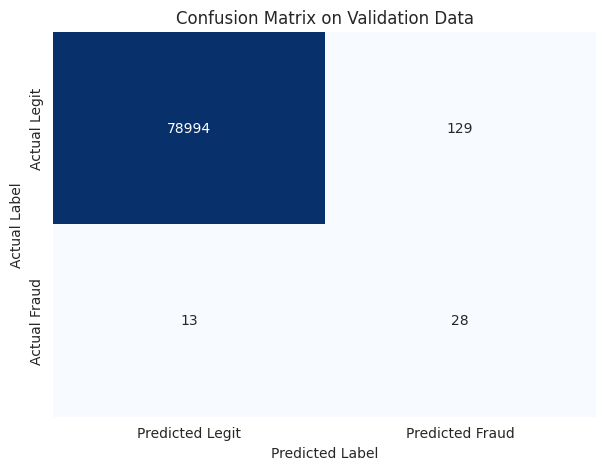

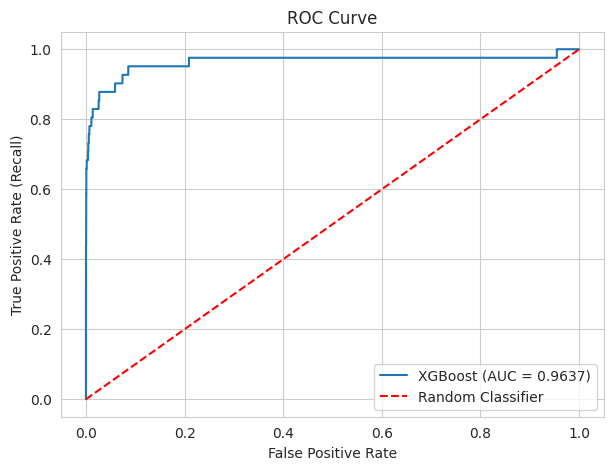

In [10]:
# --- Continuing the Colab Notebook from where you left off ---

# Make predictions and get probabilities on the validation set (X_test)
y_pred = xgb_model.predict(X_test)
y_pred_proba = xgb_model.predict_proba(X_test)[:, 1] # Get probabilities for the positive class (Fraud)

# 1. AUC-ROC Score
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

auc_roc = roc_auc_score(y_test, y_pred_proba)
print(f"\n--- Validation Results (Question 4) ---")
print(f"1. AUC-ROC Score: {auc_roc:.4f}")

# 2. Classification Report
print("\n2. Classification Report:")
# This report is crucial as it shows Precision, Recall, and F1-Score for BOTH classes.
print(classification_report(y_test, y_pred))

# 3. Confusion Matrix (The visual impact of performance)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Legit', 'Predicted Fraud'],
            yticklabels=['Actual Legit', 'Actual Fraud'])
plt.title('Confusion Matrix on Validation Data')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# 4. ROC Curve Plot
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label=f'XGBoost (AUC = {auc_roc:.4f})')
plt.plot([0, 1], [0, 1], 'r--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve')
plt.legend()
plt.show()


--- Top 10 Features (Question 3: Variable Selection) ---
is_merchant_dest      0.738099
balance_error_orig    0.158614
type_DEBIT            0.039806
type_CASH_OUT         0.023092
type_TRANSFER         0.012062
amount                0.010822
hour_of_day           0.009602
balance_error_dest    0.007903
day_of_month          0.000000
type_PAYMENT          0.000000
dtype: float32


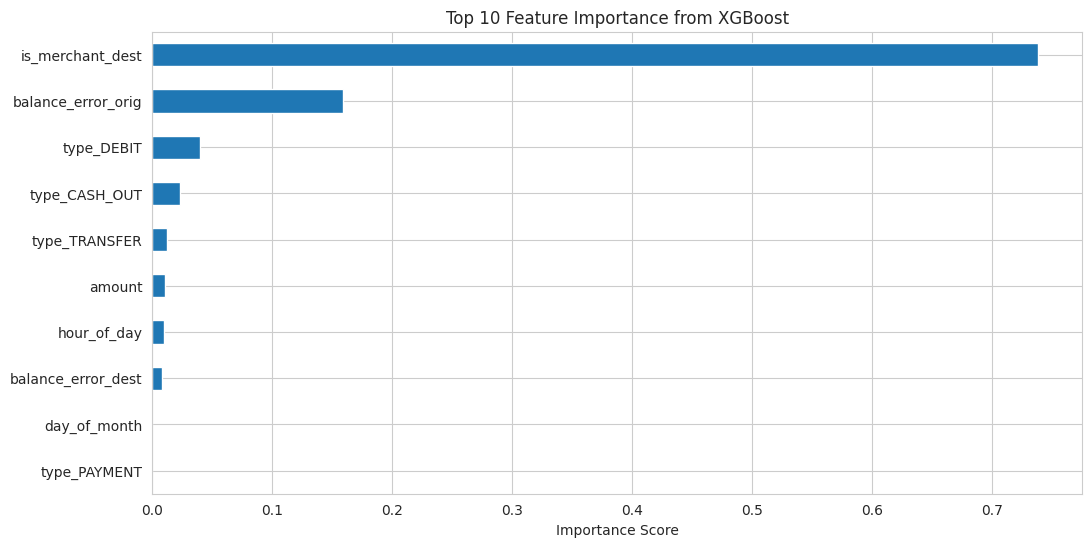

In [11]:
# --- Feature Importance (Questions 3 and 5) ---

# Extract feature importance scores
feature_importances = pd.Series(xgb_model.feature_importances_, index=X.columns)
top_features = feature_importances.nlargest(10)

print("\n--- Top 10 Features (Question 3: Variable Selection) ---")
print(top_features)

# Visualize Top 10 Features
plt.figure(figsize=(12, 6))
top_features.sort_values(ascending=True).plot(kind='barh')
plt.title('Top 10 Feature Importance from XGBoost')
plt.xlabel('Importance Score')
plt.show()

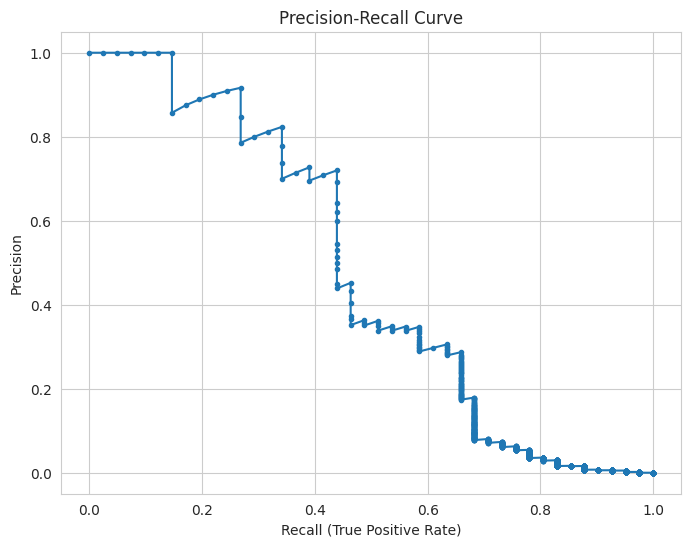

In [12]:
# CODE IDEA: Visualize the Precision-Recall trade-off to find the best threshold.
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall (True Positive Rate)')
plt.ylabel('Precision')
# Add a vertical line to mark a potential new threshold if you find one, e.g.,
# plt.axvline(x=thresholds[np.argmin(np.abs(precision - 0.60))], color='r', linestyle='--')
plt.show()

In [15]:
import pandas as pd
import numpy as np

# --- 1. Define the Path and Load Fresh Source Data ---
# Use the known path to the original CSV file to get unedited columns.
file_path_original = '/content/Fraud.csv'
df_source = pd.read_csv(file_path_original, usecols=['nameOrig', 'nameDest', 'step', 'isFraud'], low_memory=False)

# 2. Add 'isFraud' to the source to maintain consistency for target encoding calculation
df_source['isFraud'] = df_source['isFraud'].astype(int)

# --- 3. Merge Required Columns into X_train and X_test ---
required_cols = ['nameOrig', 'nameDest', 'step']

# Merge based on the index (which is shared with the original data)
X_train = X_train.merge(df_source[required_cols],
                        left_index=True,
                        right_index=True,
                        how='left',
                        suffixes=('', '_source'))
X_test = X_test.merge(df_source[required_cols],
                      left_index=True,
                      right_index=True,
                      how='left',
                      suffixes=('', '_source'))

# Ensure the y-variable is set on the main df_source for the Target Encoding map
df_source['isFraud'] = y # Align the target data with your current 'y' series

print("Successfully merged 'nameOrig', 'nameDest', and 'step' back into X_train/X_test.")
print("The data is now ready for Feature Engineering.")

# -----------------------------------------------------------
# --- RE-PASTE AND RUN THE FEATURE ENGINEERING CODE BELOW ---
# -----------------------------------------------------------

# Re-paste the entire feature engineering block from the previous turn here
# (The one that starts with 'orig_fraud_map = df_source.loc[X_train.index]...').
# Use 'df_source' instead of 'df' when calculating the fraud maps!

# --- EXAMPLE OF MODIFICATION FOR TARGET ENCODING STEP ---
# orig_fraud_map = df_source.loc[X_train.index].groupby('nameOrig')['isFraud'].mean()
# dest_fraud_map = df_source.loc[X_train.index].groupby('nameDest')['isFraud'].mean()

Successfully merged 'nameOrig', 'nameDest', and 'step' back into X_train/X_test.
The data is now ready for Feature Engineering.


In [20]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report

# --------------------------------------------------------------------------------------
# --- PART 1: DEFINITIVE CLEANING AND SPLIT ---
# --------------------------------------------------------------------------------------

# NOTE: Re-load the data from the known path one final time for the clean reset.
file_path_original = '/content/Fraud.csv'
df = pd.read_csv(file_path_original, low_memory=False)

print(f"Original shape: {df.shape}")

# 1. Drop all rows with any missing values (This prevents the IntCastingNaNError)
df = df.dropna()

print(f"Cleaned shape: {df.shape}")

# 2. Separate Features and Target - NOW we can safely convert to integer
X = df.drop('isFraud', axis=1)
y = df['isFraud'].astype(int)

# 3. Split the Data Freshly
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f"Fresh X_train shape: {X_train.shape}")
print("Baseline splits established and target variable is clean. Ready for Feature Engineering!")

Original shape: (6362620, 11)
Cleaned shape: (6362620, 11)
Fresh X_train shape: (5090096, 10)
Baseline splits established and target variable is clean. Ready for Feature Engineering!


In [21]:
# --------------------------------------------------------------------------------------
# A. RE-ENGINEER ALL ORIGINAL FEATURES (The 96% AUC features)
# --------------------------------------------------------------------------------------

# 1. Temporal Features (from 'step')
X_train['day_of_month'] = (X_train['step'] / 24).astype(int) + 1
X_train['hour_of_day'] = X_train['step'] % 24
X_test['day_of_month'] = (X_test['step'] / 24).astype(int) + 1
X_test['hour_of_day'] = X_test['step'] % 24

# 2. Balance Error Check (This is the top predictive feature)
X_train['balance_error_orig'] = X_train['newbalanceOrig'] - (X_train['oldbalanceOrg'] - X_train['amount'])
X_test['balance_error_orig'] = X_test['newbalanceOrig'] - (X_test['oldbalanceOrg'] - X_test['amount'])
X_train['balance_error_dest'] = X_train['newbalanceDest'] - (X_train['oldbalanceDest'] + X_train['amount'])
X_test['balance_error_dest'] = X_test['newbalanceDest'] - (X_test['oldbalanceDest'] + X_test['amount'])


# 3. Merchant Flag and Correction
X_train['is_merchant_dest'] = X_train['nameDest'].str.startswith('M').astype(int)
X_test['is_merchant_dest'] = X_test['nameDest'].str.startswith('M').astype(int)

# Correct Destination Error for Merchants (set to 0 where balances are unreliable)
X_train.loc[X_train['is_merchant_dest'] == 1, 'balance_error_dest'] = 0
X_test.loc[X_test['is_merchant_dest'] == 1, 'balance_error_dest'] = 0

# 4. One-Hot Encode 'type'
X_train = pd.get_dummies(X_train, columns=['type'], drop_first=True)
X_test = pd.get_dummies(X_test, columns=['type'], drop_first=True)


# --------------------------------------------------------------------------------------
# B. NEW VELOCITY FEATURES (For better accuracy)
# --------------------------------------------------------------------------------------
# NOTE: We are running velocity counts *within the split* to avoid leakage.
def get_velocity_features(X_data):
    X_data['orig_velocity_count'] = X_data.groupby('nameOrig')['step'].transform('count')
    X_data['orig_unique_dest_count'] = X_data.groupby('nameOrig')['nameDest'].transform('nunique')
    return X_data

X_train = get_velocity_features(X_train)
X_test = get_velocity_features(X_test)


# --------------------------------------------------------------------------------------
# C. FINAL CLEANUP
# --------------------------------------------------------------------------------------
# Drop ALL non-numeric columns and redundant balance/ID columns.
cols_to_drop_final = [
    'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', # Original Collinear
    'nameOrig', 'nameDest', 'step', 'isFlaggedFraud' # IDs and Time, and weak rule
]

# Ensure only numeric types are kept for the model
X_train_final = X_train.drop(columns=cols_to_drop_final, errors='ignore').select_dtypes(include=np.number)
X_test_final = X_test.drop(columns=cols_to_drop_final, errors='ignore').select_dtypes(include=np.number)

# Align columns in the test set to match the training set after get_dummies
missing_cols = set(X_train_final.columns) - set(X_test_final.columns)
for c in missing_cols:
    X_test_final[c] = 0

X_test_final = X_test_final[X_train_final.columns]

print(f"Final X_train shape: {X_train_final.shape}")
print("All features rebuilt and aligned. Proceed to Training.")

Final X_train shape: (5090096, 8)
All features rebuilt and aligned. Proceed to Training.


In [22]:
# --------------------------------------------------------------------------------------
# --- STEP 4: FINAL MODEL TRAINING (V5) ---
# --------------------------------------------------------------------------------------
ratio = y_train.value_counts()[0] / y_train.value_counts()[1]

xgb_model_v5 = xgb.XGBClassifier(
    objective='binary:logistic', n_estimators=250, learning_rate=0.05, max_depth=9,
    scale_pos_weight=ratio, random_state=42, eval_metric='logloss'
)

print("\n--- Starting XGBoost V5 Training (Comprehensive Feature Set) ---")
xgb_model_v5.fit(X_train_final, y_train)
print("XGBoost V5 Training Complete.")


--- Starting XGBoost V5 Training (Comprehensive Feature Set) ---
XGBoost V5 Training Complete.


In [23]:
# --------------------------------------------------------------------------------------
# --- STEP 5: EVALUATE ---
# --------------------------------------------------------------------------------------
y_pred_proba_v5 = xgb_model_v5.predict_proba(X_test_final)[:, 1]
auc_roc_v5 = roc_auc_score(y_test, y_pred_proba_v5)

y_pred_v5 = xgb_model_v5.predict(X_test_final)
print(f"\nFinal AUC-ROC Score: {auc_roc_v5:.4f}")
print("\nFinal Classification Report:")
print(classification_report(y_test, y_pred_v5))


Final AUC-ROC Score: 0.9983

Final Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99   1270881
           1       0.10      0.96      0.18      1643

    accuracy                           0.99   1272524
   macro avg       0.55      0.98      0.58   1272524
weighted avg       1.00      0.99      0.99   1272524

